# COVID-19 Study with WHO Statistics

This is my first Jupyter notebook!

In [1]:
from datetime import timedelta, date, datetime
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import requests
import tabula

In [2]:
# set up display area to show dataframe in jupyter qtconsole

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
##################################################
# Country populations
##################################################

df_pop = pd.read_csv('Countries.csv', encoding='utf-8', index_col='Country')

In [4]:
##################################################
# Check whether the data already exists on disk
##################################################

first_dt = datetime.strptime('2020-01-21',"%Y-%m-%d")
first_rep = 1

if os.path.exists('COVID-19_WHO_Cases.csv'):
    print("Database exists - Reading it")

    df_cases = pd.read_csv('COVID-19_WHO_Cases.csv', encoding='utf-8', index_col='Country')
    df_deaths = pd.read_csv('COVID-19_WHO_Deaths.csv', encoding='utf-8', index_col='Country')

    start_dt = datetime.strptime(df_cases.columns.values[-1],'%Y-%m-%d') + timedelta(1)
    start_rep = first_rep + int ((start_dt - first_dt).days)
else:
    print("Database does not exist - Building it")

    ##################################################
    # Hard-code first data
    ##################################################
    
    df_cases = df_pop.copy()
    df_deaths = df_pop.copy()

    start_dt = datetime.strptime('2020-02-03',"%Y-%m-%d")
    start_rep = 14
    
end_dt = datetime.now() - timedelta(1)
end_rep = first_rep + int ((end_dt - first_dt).days)

Database exists - Reading it


In [5]:
##################################################
# Update data if needed
##################################################

for dt in range(int ((end_dt - start_dt).days)+1):
    new_date = start_dt + timedelta(dt)
    new_rep = start_rep + dt
    if new_rep >= 24:
        who_file = new_date.strftime("%Y%m%d")+"-sitrep-"+str(new_rep)+"-covid-19.pdf"
    else:
        who_file = new_date.strftime("%Y%m%d")+"-sitrep-"+str(new_rep)+"-ncov.pdf"
        
    new_date = new_date.strftime("%Y-%m-%d")
    print("Adding "+new_date+" to database")

    file = "WHO/"+who_file

    ##################################################
    # Download file from WHO if not on disk
    ##################################################

    if not os.path.exists(file):
        print("File missing - Downloading "+file)
        response = requests.get("https://www.who.int/docs/default-source/coronaviruse/situation-reports/"+who_file)
        if response.status_code >= 400:
            print("Does not exist")
            sys.exit()
        else:
            with open(file, 'wb') as f:
                f.write(response.content)

    ##################################################
    # Get World statistics
    ##################################################

    tab_who = tabula.read_pdf(file, pages="all", silent=True, pandas_options={'header': None})

    if len(tab_who) > 0:
        df_who = pd.concat(tab_who)
        cols = list(i for i in range(7,len(df_who.columns),1))
        df_who.drop(df_who.columns[cols], axis=1, inplace = True)
        df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
        df_who.replace(to_replace = '\s*\[.*\]', value = '', regex = True, inplace = True)

        if new_rep >= 42:
            # Format for reports 42+
            df_who.drop(df_who.columns[[2,4,5,6]], axis=1, inplace = True)
        elif new_rep >= 39:
            # Format for reports 39-41, fewer columns than the rest
            cols = list(i for i in range(3,len(df_who.columns),1))
            df_who.drop(df_who.columns[cols], axis=1, inplace = True)
        elif new_rep == 38:
            # Format for reports 38
            tab_who[2].drop(tab_who[2].columns[[2,3,4]], axis=1, inplace = True)
            tab_who[3].drop(tab_who[3].columns[[2,3,4,5]], axis=1, inplace = True)
            df_who = pd.concat(tab_who)
            df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
            df_who.replace(to_replace = '\s*\[.*\]', value = '', regex = True, inplace = True)
        elif new_rep == 31:
            # Special format for report 31, as Cases get merged into the country
            df_who = tab_who[1]
            df_who.replace(to_replace = '\s*\(.*\)', value = '', regex = True, inplace = True)
            df_who = df_who[df_who.columns[0]].str.rsplit(' ', 1, expand = True)
            df_who[2] = tab_who[1][4]
        elif new_rep >= 30:
            # Format for reports 30 and 32-37
            df_who.drop(df_who.columns[[2,3,4]], axis=1, inplace = True)
        elif new_rep >= 25:
            # Format for reports 25-29
            df_who.drop(df_who.columns[[1,3,4,5]], axis=1, inplace = True)
        elif new_rep >= 23:
            # Format for reports 23-24
            df_who.drop(df_who.columns[[0,3,4]], axis=1, inplace = True)
        elif new_rep == 17:
            # Format for reports 17
            df_who.drop(df_who.columns[[1,3,4,5]], axis=1, inplace = True)
        elif new_rep >= 14:
            # Format for reports 14-16 and 18-22
            df_who.drop(df_who.columns[[0,3]], axis=1, inplace = True)
        else:
            print("Not programmed to extract this report")
            sys.exit()

        df_who.replace(to_replace = '\s\d*$', value = '', regex = True, inplace = True)
        df_who = df_who[pd.to_numeric(df_who[df_who.columns[1]], errors='coerce').notnull()]
        df_who = df_who[pd.to_numeric(df_who[df_who.columns[2]], errors='coerce').notnull()]
        df_who.dropna(inplace = True)
        df_who.reset_index(drop = True, inplace = True)
        #df_who.drop(df_who.index[0], inplace = True)
            
        df_who.rename(columns = {df_who.columns[0]:'Country',df_who.columns[1]:'Cases',df_who.columns[2]:'Deaths'},
            inplace=True)
        df_who['Country'] = df_who['Country'].astype(str)
        df_who['Cases'] = df_who['Cases'].astype(int)
        df_who['Deaths'] = df_who['Deaths'].astype(int)
        
        df_who['Country'] = df_who['Country'].str.replace('’','\'')
        df_who['Country'] = df_who['Country'].str.replace('\r',' ')
        df_who['Country'] = df_who['Country'].str.replace('\W*$','')
        df_who['Country'] = df_who['Country'].str.replace('^Bahamas','The Bahamas')
        df_who['Country'] = df_who['Country'].str.replace('Bonaire, Sint Eustatius and Saba',
                                                          'Caribbean Netherlands')
        df_who['Country'] = df_who['Country'].str.replace('Brunei Darussalam','Brunei')
        df_who['Country'] = df_who['Country'].str.replace('^Congo','Republic of the Congo')
        df_who['Country'] = df_who['Country'].str.replace('.*Ivoire','Ivory Coast')
        df_who['Country'] = df_who['Country'].str.replace('Holy See','Vatican')
        df_who['Country'] = df_who['Country'].str.replace('Eswatini', 'eSwatini')
        df_who['Country'] = df_who['Country'].str.replace('^Lao.*', 'Laos')
        df_who['Country'] = df_who['Country'].str.replace('occupied Palestinian territory','Palestine')
        df_who['Country'] = df_who['Country'].str.replace('Republic of Korea', 'South Korea')
        df_who['Country'] = df_who['Country'].str.replace('Republic of Moldova', 'Moldova')
        df_who['Country'] = df_who['Country'].str.replace('Russian Federation', 'Russia')
        df_who['Country'] = df_who['Country'].str.replace('Saint Barthélemy','Saint Barthelemy')
        df_who['Country'] = df_who['Country'].str.replace('Serbi.*','Republic of Serbia')
        df_who['Country'] = df_who['Country'].str.replace('Syrian Arab Republic','Syria')
        df_who['Country'] = df_who['Country'].str.replace('Timor-Leste','East Timor')
        df_who['Country'] = df_who['Country'].str.replace('The United','United')
        df_who['Country'] = df_who['Country'].str.replace('^Kingdom','United Kingdom')
        df_who['Country'] = df_who['Country'].str.replace('Viet Nam','Vietnam')
        
        df_who['Country'] = df_who['Country'].str.replace('conveyance','Diamond Princess')

        df_who.set_index('Country', inplace = True)
        df_who.to_csv('WHO/'+new_date+'.csv', index = True, encoding='utf-8')

        df_cases[new_date] = df_who['Cases']
        df_deaths[new_date] = df_who['Deaths']
        
end_dt = end_dt.strftime("%Y-%m-%d")

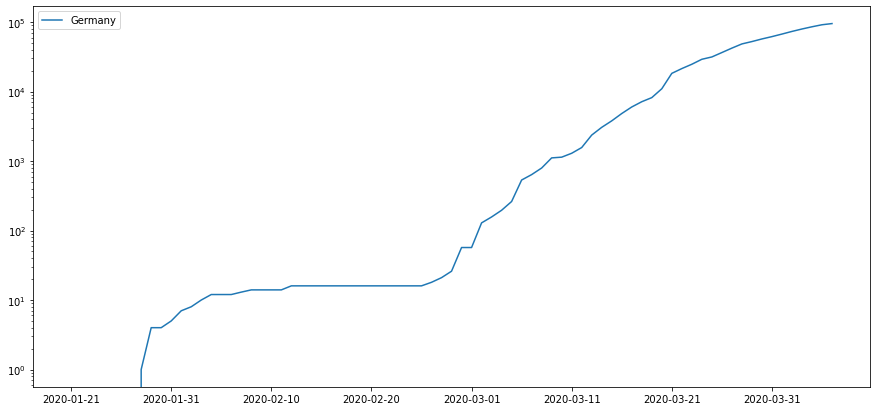

In [6]:
##################################################
# Save and plot data
##################################################

df_cases.to_csv('COVID-19_WHO_Cases.csv', index = True, encoding='utf-8')
df_deaths.to_csv('COVID-19_WHO_Deaths.csv', index = True, encoding='utf-8')

df_cases.fillna(0, inplace = True)
df_deaths.fillna(0, inplace = True)

df_germany = df_cases.drop(['Continental Region','Statistical Region','Population'], axis=1).loc['Germany']
df_germany.plot(figsize=(15,7),legend=True)
plt.yscale('log')
plt.savefig("COVID-19_WHO.png")

In [79]:
##################################################
# Plot world map using geopandas
##################################################
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.models import Slider, HoverTool, TapTool, RadioButtonGroup, DatetimeTickFormatter
from bokeh.palettes import brewer, Category20_16
from bokeh.layouts import widgetbox, row, column
from bokeh.themes import Theme
import geopandas as gpd
import json

output_notebook()

Loading BokehJS ...

In [110]:
geofile = '/home/martel/.local/share/cartopy/shapefiles/natural_earth/cultural/ne_110m_admin_0_countries.shp'

df_geo = gpd.read_file(geofile)[['ADMIN', 'ADM0_A3', 'geometry']]
df_geo.columns = ['Country','Code','geometry']

# 2019 update of Macedonia to North Macedonia
df_geo['Country'] = df_geo['Country'].str.replace('Macedonia','North Macedonia')

# Remove Antarctica
df_geo.drop([159], inplace = True)

df_geo = df_geo.explode()

df_map = df_geo.merge(df_cases, left_on = 'Country', right_on = 'Country', how = 'left')

df_map['Cases_Tot'] = df_map[end_dt]
df_map['Cases_Per'] = 1000*df_map[end_dt]/df_map['Population']

#Read data to json.
df_map_json = json.loads(df_map.to_json())

#Convert to String like object.
json_map = json.dumps(df_map_json)

#Input GeoJSON source that contains features for plotting.
source_map = GeoJSONDataSource(geojson = json_map)

df_tap = df_cases.drop(['Continental Region','Statistical Region','Population'], axis=1).T
df_tap.reset_index(inplace = True)
df_tap.rename(columns = {df_tap.columns[0]:'Date'}, inplace=True)
df_tap['Date'] = pd.to_datetime(df_tap['Date'])
df_tap['World'] = df_tap.apply(lambda row: row[1 : -1].sum(),axis=1)
df_tap['ToolTipDate'] = df_tap.Date.map(lambda x: x.strftime("%b %d")) # Saves work with the tooltip later
df_tap['Cases'] = df_tap['World']
source_tap = ColumnDataSource(df_tap)

df_grp = df_tap[['Date', 'ToolTipDate', 'World']].copy()
df_grp.columns = ['Date', 'ToolTipDate', 'Cases']
df_grp['Country'] = 'World'
df_grp['Color'] = Category20_16[0]
df_grp = df_sum.sort_values(['Country', 'Date'])
source_grp = ColumnDataSource(df_grp)

def myapp(doc):
    #Define a sequential multi-hue color palette.
    palette = brewer['YlGnBu'][8]

    #Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]

    start_dt = datetime.strptime('2020-01-21',"%Y-%m-%d")
    start_rep = 1
    
    show_dt = end_dt
    show_rep = end_rep

    def make_map(setting):
        #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
        if setting == 0:
            max_val = max(df_map['Cases_Tot'])
            tick_labels = {'0':'0', '50000':'50k', '100000':'100k', '150000':'150k', '200000':'200k', 
                           '250000':'250k', '300000':'300k', '350000':'350k', '400000':'400k', '500000':'500k'}
            plot_col = 'Cases_Tot'
        else:
            max_val = max(df_map['Cases_Per'])
            tick_labels = {'0.5':'1/2000', '1':'1/1000', '1.5':'1/666', '2':'1/500', '2.5':'1/400', '3':'1/333', 
                           '3.5':'1/286', '4':'1/250', '4.5':'1/222', '5':'1/200'}
            plot_col = 'Cases_Per'
            
        color_mapper = LinearColorMapper(palette = palette, low = 0, high = max_val)

        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width = 500, height = 20, 
                             border_line_color=None, location = (0,0), orientation = 'horizontal', 
                             major_label_overrides = tick_labels)

        #Add hover tool
        hover = HoverTool(tooltips = [('Country/region','@Country'), ('Cases','@Cases_Tot'), 
                                      ('Population','@Population'), ('Cases/1k Ppl','@Cases_Per')])

        #Create figure object.
        p = figure(title = 'Map of COVID-19 Cases (WHO)', plot_height = 600 , plot_width = 950, 
                   toolbar_location = 'right', tools = 'pan, wheel_zoom, box_zoom, reset, tap')
        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None

        #Add patch renderer to figure. 
        p.patches('xs','ys', source = source_map, fill_color = {'field' : plot_col, 'transform' : color_mapper},
                  line_color = 'black', line_width = 0.25, fill_alpha = 1)

        #Specify figure layout.
        p.add_layout(color_bar, 'below')
        p.add_tools(hover)
        
        return p

    # Define the callback function: update_map
    def update_map(attr, old, new):
        show_rep = slider.value
        show_dt = (start_dt + timedelta(show_rep-start_rep)).strftime("%Y-%m-%d")
        df_map['Cases_Tot'] = df_map[show_dt]
        df_map['Cases_Per'] = 1000*df_map[show_dt]/df_map['Population']
        df_map_json = json.loads(df_map.to_json())
        json_map = json.dumps(df_map_json)
        source_map.geojson = json_map
    
    def make_lin(setting):
        #Create figure object.
        p = figure(title = 'Linear Plot of COVID-19 Cases (WHO)', plot_height = 450 , plot_width = 450, 
                   x_axis_type = 'datetime', toolbar_location = 'right', 
                   tools = 'pan, wheel_zoom, box_zoom, reset')
        
        # Format your x-axis as datetime.
        p.xaxis[0].formatter = DatetimeTickFormatter(days='%b %d')

        p.line(x = 'Date', y = 'Cases', source=source_tap, line_width=3, line_alpha=0.6)

        # Add your tooltips
        p.add_tools(HoverTool(tooltips= [('Date','@ToolTipDate'), ('Cases','@Cases')]))

        return p
    
    def make_log(setting):
        #Create figure object.
        p = figure(title = 'Logarithmic Plot of COVID-19 Cases (WHO)', plot_height = 450 , plot_width = 450, 
                   x_axis_type = 'datetime', y_axis_type = 'log', toolbar_location = 'right', 
                   tools = 'pan, wheel_zoom, box_zoom, reset')
        
        # Format your x-axis as datetime.
        p.xaxis[0].formatter = DatetimeTickFormatter(days='%b %d')

        p.line(x = 'Date', y = 'Cases', source=source_tap, line_width=3, line_alpha=0.6)

        # Add your tooltips
        p.add_tools(HoverTool(tooltips= [('Date','@ToolTipDate'), ('Cases','@Cases')]))

        return p
    
    def make_test(setting):
        #Create figure object.
        p = figure(title = 'Test Plot of COVID-19 Cases (WHO)', plot_height = 450 , plot_width = 450, 
                   x_axis_type = 'datetime', toolbar_location = 'right', 
                   tools = 'pan, wheel_zoom, box_zoom, reset')
        
        # Format your x-axis as datetime.
        p.xaxis[0].formatter = DatetimeTickFormatter(days='%b %d')
        
        
        #p.line(x = 'Date', y = 'Cases', legend_group = 'Country', source=source_grp, line_width=3, line_alpha=0.6)
        p.circle(x = 'Date', y = 'Cases', source=source_grp, fill_color = 'Color', line_color = 'Color', legend_group = 'Country')

        # Add your tooltips
        p.add_tools(HoverTool(tooltips= [('Date','@ToolTipDate'), ('Country/region','@Country'), 
                                         ('Cases','@Cases')]))

        return p

    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        try:
            selected_index = source_map.selected.indices[0]
            selected_country = df_map.iloc[selected_index]['Country']
            df_tap['Cases'] = df_tap[selected_country]
            source_tap.data = df_tap
            
            for i, country in enumerate(source_map.selected.indices):
            df_set1 = df_tap[['Date', 'ToolTipDate', 'Germany']].copy()
            df_set1.columns = ['Date', 'ToolTipDate', 'Cases']
            df_set1['Country'] = 'Germany'
            df_set1['Color'] = Category20_16[0]
            df_set2 = df_tap[['Date', 'ToolTipDate', 'Italy']].copy()
            df_set2.columns = ['Date', 'ToolTipDate', 'Cases']
            df_set2['Country'] = 'Italy'
            df_set2['Color'] = Category20_16[3]
            df_sum = df_set1.append(df_set2, ignore_index=True)

        except IndexError:
            #update_plot('World')
            pass
        
    def change_var(attr, old, new):        
        doc.clear()
        doc.add_root(column(radio_button, slider, make_map(radio_button.active), 
                            row(make_lin(radio_button.active), make_log(radio_button.active))))
    
    # Make a slider object: slider 
    slider = Slider(title = 'Report', start = start_rep, end = end_rep, step = 1, value = end_rep)
    slider.on_change('value', update_map)
    
    source_map.selected.on_change('indices', update_plot)

    # Make a selection of what to plot
    radio_button = RadioButtonGroup(labels=['Cases', 'Cases/Pop'], active=0)
    radio_button.on_change('active', change_var)

    # Make a column layout of widgetbox(slider) and plot, and add it to the current document
    doc.add_root(column(radio_button, slider, make_map(0), row(make_lin(0), make_log(0)), make_test(0)))

In [111]:
show(myapp)